In [ ]:
from pathlib import Path
from typing import Dict, List, Tuple, Any, Optional
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
from molencoder.evaluation.statistical_evaluation import repeated_measures_anova, tukey_hsd
import matplotlib.colors as mcolors


def load_and_prepare_data(csv_path: str, model_name_mapping: Dict[str, str], max_folds: int = None) -> Dict[str, pd.DataFrame]:
    """
    Load the CSV file and prepare data for each metric.
    
    Args:
        csv_path: Path to the CSV file containing evaluation results
        model_name_mapping: Dictionary mapping full model names to short names
        max_folds: Maximum number of folds to include (useful for balancing datasets)
        
    Returns:
        Dictionary with metric names as keys and prepared DataFrames as values
    """
    # Load the CSV file
    df = pd.read_csv(csv_path)

    # Map model names to concise versions
    df['model'] = df['model'].map(model_name_mapping)
    
    # Filter to only include folds up to max_folds if specified
    if max_folds is not None:
        df = df[df['fold'] < max_folds]
    
    # Create a dictionary to store prepared data for each metric
    prepared_data = {}
    
    # Get unique metrics
    metrics = df['metric_name'].unique()
    
    for metric in metrics:
        # Filter data for current metric
        metric_data = df[df['metric_name'] == metric]
        
        # Pivot the data to have models as columns and folds as rows
        pivot_data = metric_data.pivot(
            index='fold',
            columns='model',
            values='value'
        )
        
        prepared_data[metric] = pivot_data
    
    return prepared_data


def find_best_model(data: pd.DataFrame, metric_name: str) -> str:
    """
    Find the best performing model based on the metric values.
    For MAE and MSE, lower is better. For R2 and rho, higher is better.
    
    Args:
        data: DataFrame with models as columns and metric values as rows
        metric_name: Name of the metric being evaluated
        
    Returns:
        Name of the best performing model
    """
    # Calculate mean performance for each model
    model_means = data.mean()
    
    if metric_name in ['mae', 'mse']:
        # For MAE and MSE, lower is better
        best_model = model_means.idxmin()
    else:
        # For R2 and rho, higher is better
        best_model = model_means.idxmax()
    
    return best_model


def clean_prepared_data(prepared_data: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    """
    Clean the prepared data by removing 'nan' columns and handling missing values.
    
    Args:
        prepared_data: Dictionary with metric names as keys and DataFrames as values
        
    Returns:
        Cleaned dictionary with metric names as keys and DataFrames as values
    """
    cleaned_data = {}
    
    for metric_name, metric_data in prepared_data.items():
        # Drop the 'nan' column if it exists
        if 'nan' in metric_data.columns:
            cleaned_data[metric_name] = metric_data.drop(columns=['nan'])
        # Also handle NaN as actual NaN values
        elif len(metric_data.columns) > 0 and metric_data.columns[0] != metric_data.columns[0]:  # Check for actual NaN column name
            cleaned_data[metric_name] = metric_data.iloc[:, 1:]  # Skip first column
        else:
            cleaned_data[metric_name] = metric_data.copy()
    
    return cleaned_data


def analyze_and_plot_experiments(
    csv_paths: List[str], 
    model_name_mapping: Dict[str, str], 
    output_dir: Optional[str] = None,
    dataset_name_transform: callable = None,
    y_axis_label: str = 'Masking Ratio',
    max_folds: int = None
) -> None:
    """
    Analyze experimental results and create plots for significant metrics.
    
    Args:
        csv_paths: List of paths to CSV files containing experimental results
        model_name_mapping: Dictionary mapping full model names to short display names
        output_dir: Optional directory to save the generated plots. If None, plots are only displayed.
        dataset_name_transform: Optional function to transform dataset names from file paths
        y_axis_label: Label for the y-axis (default: 'Masking Ratio')
        max_folds: Maximum number of folds to include for balanced analysis (default: None)
    """
    # Create output directory if it doesn't exist and is provided
    if output_dir is not None:
        Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Collect all data first
    all_data = {}
    for csv_path in csv_paths:
        # Extract dataset name from path
        if dataset_name_transform:
            dataset_name = dataset_name_transform(csv_path)
        else:
            # Default transformation
            dataset_name = (Path(csv_path).stem
                          .replace('_results', '')
                          .replace('adme-fang-', '')
                          .replace('-1', '')
                          .replace("hclint", "HCLint")
                          .replace("perm", "Permeability")
                          .replace("solu", "Solubility")
                          .replace("-astrazeneca", "")
                          .replace("adme-novartis-", "")
                          .replace("-reg", "")
                          .replace("PERM", "Permeability")
                          .replace("SOLU", "Solubility")
                          .replace("HCLINT", "HCLint")
                          .replace("lipophilicity", "Lipophilicity")
                          .replace("cyp3a4", "CYP"))
        
        # Only limit folds for Cyp3a4 dataset to handle unbalanced data
        current_max_folds = 8 if 'cyp3a4' in csv_path.lower() else None
        prepared_data = load_and_prepare_data(csv_path, model_name_mapping, current_max_folds)
        cleaned_data = clean_prepared_data(prepared_data)
        all_data[dataset_name] = cleaned_data

    # Get all unique metrics
    all_metrics = set()
    for dataset_data in all_data.values():
        all_metrics.update(dataset_data.keys())

    # Create subplots for each metric
    for metric in all_metrics:
        # Check if any dataset has significant results for this metric
        has_significant = False
        significant_datasets = []
        
        for dataset_name, dataset_data in all_data.items():
            if metric in dataset_data:
                try:
                    anova_results = repeated_measures_anova(dataset_data[metric])
                    if anova_results['p_value'] < 0.05:
                        has_significant = True
                        significant_datasets.append((dataset_name, dataset_data[metric]))
                    else:
                        print(f"Non-significant result for {dataset_name} - {metric}: p = {anova_results['p_value']:.4f}")
                except Exception as e:
                    print(f"Error with {dataset_name} - {metric}: {e}")
                    continue
        
        if has_significant:
            print(f"Significant differences found for {metric} with p-value {anova_results['p_value']}")
            
            # Determine number of subplots needed (max 5)
            num_plots = min(len(significant_datasets), 5)
            
            # Create figure with subplots - wider to accommodate 5 plots
            fig, axes = plt.subplots(1, num_plots, figsize=(12, 2.5), sharey=True)
            
            # Handle single subplot case
            if num_plots == 1:
                axes = [axes]
            
            # Plot for each dataset
            for i, (dataset_name, metric_data) in enumerate(significant_datasets[:5]):
                # Find best model and perform Tukey test
                best_model = find_best_model(metric_data, metric)
                tukey_results = tukey_hsd(metric_data)
                
                # Plot on the specific subplot
                tukey_results['results'].plot_simultaneous(
                    comparison_name=best_model, 
                    ax=axes[i]
                )
                axes[i].set_title(dataset_name, fontsize=10, color='#666666')
                axes[i].set_xlabel(metric.upper(), fontsize=10, color='#666666')
                
                # Set different colors for x and y tick labels based on subplot position
                axes[i].tick_params(axis='x', labelsize=8, colors='#666666')
                
                if i == 0:  # First subplot: darker grey for y-axis
                    axes[i].tick_params(axis='y', labelsize=8, colors='#333333')
                else:  # Other subplots: light grey like spines
                    axes[i].tick_params(axis='y', labelsize=8, colors='#CCCCCC')
                
                # Make borders light grey
                for spine in axes[i].spines.values():
                    spine.set_color('#CCCCCC')
                    spine.set_linewidth(0.8)
                
                # Remove lowest and highest y-axis ticks
                yticks = axes[i].get_yticks()
                if len(yticks) > 2:
                    new_yticks = yticks[1:-1]
                    axes[i].set_yticks(new_yticks)
            
            # Keep only the overall y-axis label
            fig.text(0.06, 0.5, y_axis_label, va='center', rotation='vertical', 
                    fontsize=11, color='#666666')
            
            plt.tight_layout()
            plt.subplots_adjust(left=0.12)
            
            # Save the figure in both PDF and PNG formats if output_dir is provided
            if output_dir is not None:
                base_output_path = Path(output_dir) / f'{metric}_comparison'
                
                # Save as PNG
                png_path = base_output_path.with_suffix('.png')
                plt.savefig(png_path, dpi=300, bbox_inches='tight')
                print(f"Saved PNG plot for {metric} to {png_path}")
                
                # Save as PDF
                pdf_path = base_output_path.with_suffix('.pdf')
                plt.savefig(pdf_path, bbox_inches='tight')
                print(f"Saved PDF plot for {metric} to {pdf_path}")
            
            plt.show()
        else:
            print(f"No significant differences found for {metric}")

Significant differences found for mse with p-value 5.243768440173988e-42
Saved PNG plot for mse to /Users/fabian/Code/smilesencoder/plots/dataset_sizes_extended/mse_comparison.png
Saved PDF plot for mse to /Users/fabian/Code/smilesencoder/plots/dataset_sizes_extended/mse_comparison.pdf


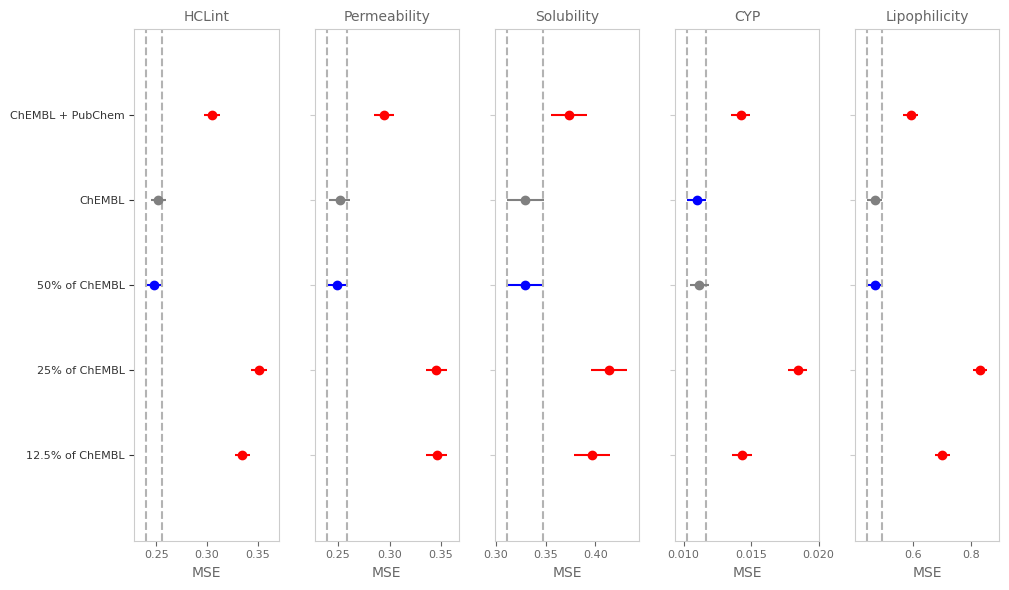

Significant differences found for rho with p-value 5.425347394360422e-42
Saved PNG plot for rho to /Users/fabian/Code/smilesencoder/plots/dataset_sizes_extended/rho_comparison.png
Saved PDF plot for rho to /Users/fabian/Code/smilesencoder/plots/dataset_sizes_extended/rho_comparison.pdf


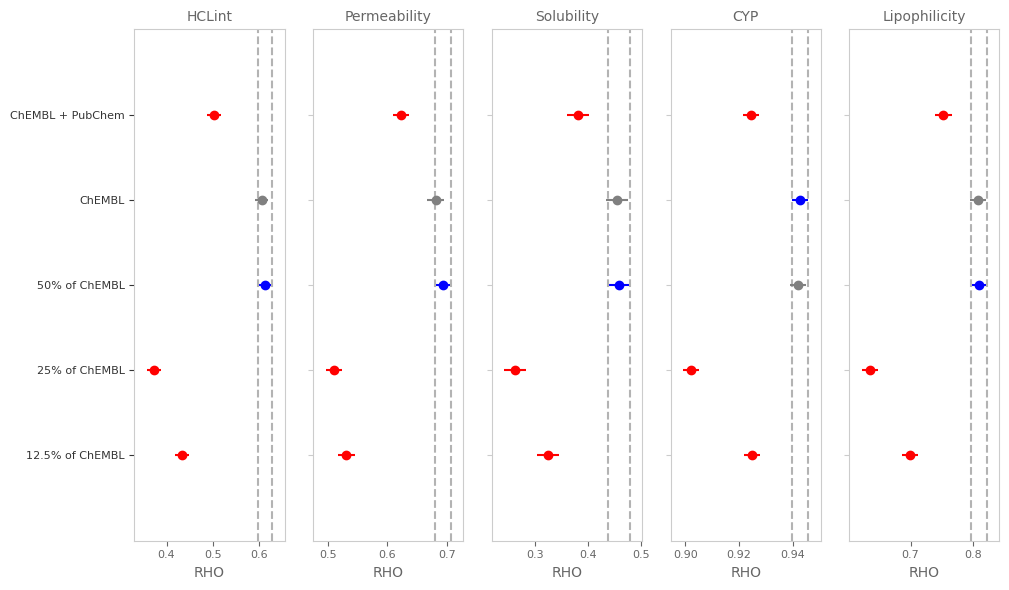

Significant differences found for mae with p-value 1.6222779521838795e-45
Saved PNG plot for mae to /Users/fabian/Code/smilesencoder/plots/dataset_sizes_extended/mae_comparison.png
Saved PDF plot for mae to /Users/fabian/Code/smilesencoder/plots/dataset_sizes_extended/mae_comparison.pdf


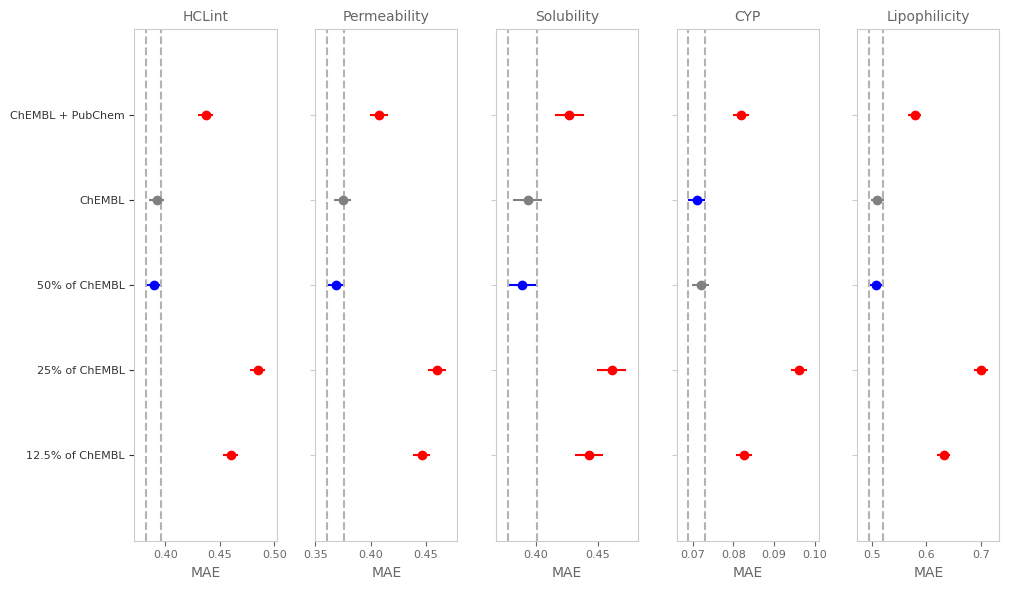

Significant differences found for r2 with p-value 3.604278525929439e-42
Saved PNG plot for r2 to /Users/fabian/Code/smilesencoder/plots/dataset_sizes_extended/r2_comparison.png
Saved PDF plot for r2 to /Users/fabian/Code/smilesencoder/plots/dataset_sizes_extended/r2_comparison.pdf


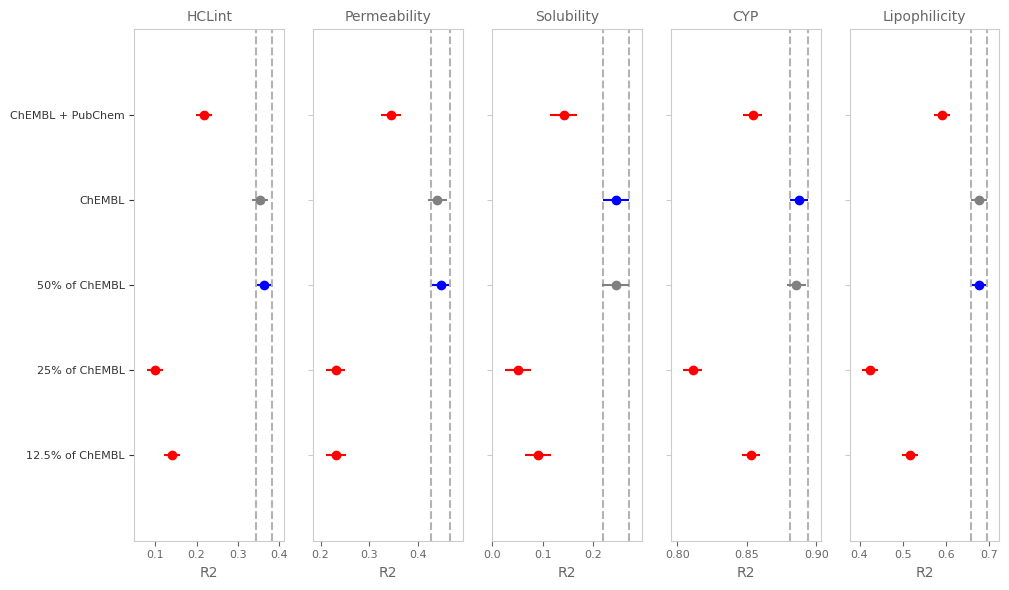

In [2]:
model_name_mapping = {
    'fabikru/model_15M_smallest_ds_masking_0.3_predicted_hparams': r'12.5% of ChEMBL',
    'fabikru/model_15M_smaller_ds_masking_0.3_predicted_hparams': r'25% of ChEMBL',
    'fabikru/model_15M_small_ds_masking_30_predicted_hparams': r'50% of ChEMBL',
    'fabikru/model_15M_medium_ds_masking_30_predicted_hparams': 'ChEMBL',
    'fabikru/model_15M_large_ds_masking_30_predicted_hparams': 'ChEMBL + PubChem',
}

csv_paths = [
    "/Users/fabian/Code/smilesencoder/experiments/result_analysis/dataset_sizes/adme-fang-hclint-1_results.csv",
    "/Users/fabian/Code/smilesencoder/experiments/result_analysis/dataset_sizes/adme-fang-perm-1_results.csv",
    "/Users/fabian/Code/smilesencoder/experiments/result_analysis/dataset_sizes/adme-fang-solu-1_results.csv",
    "/Users/fabian/Code/smilesencoder/experiments/result_analysis/dataset_sizes/adme-novartis-cyp3a4-reg_results.csv",
    "/Users/fabian/Code/smilesencoder/experiments/result_analysis/dataset_sizes/lipophilicity-astrazeneca_results.csv"
]

output_path = Path("/Users/fabian/Code/smilesencoder/plots/dataset_sizes_extended")

analyze_and_plot_experiments(csv_paths=csv_paths, model_name_mapping=model_name_mapping, output_dir=output_path, y_axis_label="")

In [ ]:
csv_paths = [
    "/Users/fabian/Code/smilesencoder/experiments/result_analysis/dataset_sizes/adme-fang-hclint-1_results.csv",
    "/Users/fabian/Code/smilesencoder/experiments/result_analysis/dataset_sizes/adme-fang-perm-1_results.csv",
    "/Users/fabian/Code/smilesencoder/experiments/result_analysis/dataset_sizes/adme-fang-solu-1_results.csv",
    "/Users/fabian/Code/smilesencoder/experiments/result_analysis/dataset_sizes/adme-novartis-cyp3a4-reg_results.csv",
    "/Users/fabian/Code/smilesencoder/experiments/result_analysis/dataset_sizes/lipophilicity-astrazeneca_results.csv"
]

model_name_mapping = {
    'fabikru/model_15M_smallest_ds_masking_0.3_predicted_hparams': '1/8 of ChEMBL',
    'fabikru/model_15M_smaller_ds_masking_0.3_predicted_hparams': '1/4 of ChEMBL',
    'fabikru/model_15M_small_ds_masking_30_predicted_hparams': '1/2 of ChEMBL',
    'fabikru/model_15M_medium_ds_masking_30_predicted_hparams': 'ChEMBL',
    'fabikru/model_15M_large_ds_masking_30_predicted_hparams': 'ChEMBL + PubChem',
}


for csv_path in csv_paths:
    # Load and prepare the data (limit to 8 folds only for Cyp3a4 dataset)
    max_folds = 8 if 'cyp3a4' in csv_path.lower() else None
    prepared_data = load_and_prepare_data(csv_path, model_name_mapping, max_folds)

    for metric, metric_data in prepared_data.items():
        # Perform repeated measures ANOVA
        anova_results = repeated_measures_anova(metric_data)
        
        # Check if the ANOVA result is significant (p < 0.05)
        if anova_results['p_value'] < 0.05:
            print(f"Significant differences found for {metric} (p = {anova_results['p_value']:.4f})")
            
            # Find the best performing model
            best_model = find_best_model(metric_data, metric)
            print(f"Best performing model for {metric}: {best_model}")
            
            # Perform Tukey's HSD test
            tukey_results = tukey_hsd(metric_data)
            
            # Create and display the plot
            plt.figure(figsize=(10, 6))
            tukey_results['results'].plot_simultaneous(comparison_name=best_model)
            plt.title(f"Tukey HSD Test Results for {metric.upper()} for {csv_path.split('/')[-1]}")
            plt.tight_layout()
            plt.show()
        else:
            print(f"No significant differences found for {csv_path} with {metric}")
